In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import xarray as xr
import pandas as pd
import os
#import aostools
import sys
import scipy.interpolate
import s2stools.events
import jinja2
import dataclasses
import metpy.calc
import datetime
import json
from eofs.xarray import Eof
#import hvplot.xarray
print(sys.path)

import pytropd.functions as tropdf
import pytropd.metrics as tropdm
import aostools.climate

from own_functions import (vertical_weights, weights, horizontal_weights, calc_jet_lats, calc_jet_lats_tropd,
    calc_theta, eof_analysis, concat_hems_in_time_xr, calc_u_eofs, calc_avg_btw_hemispheres, calc_jet_sep_index,
    get_setup_from, get_ty_from, get_tmax_from, get_fgamma_from, calc_baroclinic_slope, zero_crossings, calc_da_derivative,
    time_shifter
)
from own_functions import r_air, kappa, kappai, g0, p00, r_e

from visualization import (plot_zm_climatologies, plot_transports, plot_hor_fields, 
    plot_ep_flux_div, plot_EKE_spectral, plot_spectral_vd, plot_hayashi_spectra,
    plot_wave_persistency, plot_theta_profiles, plot_t_profiles, plot_transports,
    plot_theta_u_zm_clim, plot_bc_slope_u_zm_clim, plot_dtdz_clim)
from relax_visualization import (Params_HS_PK, Forcing_params, 
    g_func, tteh_cc_tropics, tteh_waves, tteh_mons, relax_submodel, relax_moist_adiabat
)
import dataclasses
from dataclasses import dataclass

import warnings
warnings.simplefilter(action='ignore')

pplt.rc.update({
    'figure.dpi': 100,
    'figure.figsize': (8,6),
    'savefig.dpi': 150,
})

['/home/b/b381739/masterarbeit', '/home/b/b381739/masterarbeit', '/home/b/b381739/code', '/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python39.zip', '/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9', '/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/lib-dynload', '', '/home/b/b381739/.local/lib/python3.9/site-packages', '/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages']



# Setup

In [30]:
exp_name = 'EMIL_SW90_f073'

new_trans_date = np.datetime64('1900-01-01')
ylims=[1013,10]
yscale='linear'
plot_format = 'pdf'

work_path = '/work/bd1022/b381739'
home_path = '/home/b/b381739/'
inpath = f'{work_path}/{exp_name}/postprocessed'
outpath = f'{home_path}/plots' 

os.chdir(f'{home_path}/masterarbeit')
color_json = open('colorlist.json')
colordict = json.load(color_json)
colorlist = list(colordict.values())
colorcycle = pplt.Cycle(colordict.values())

In [10]:
os.chdir(inpath)

ds_zm = xr.open_dataset(f'{exp_name}_zm_pp.nc').sortby('time')
ds_pls = xr.open_dataset(f'{exp_name}_pl_sel.nc').sortby('time')
ds_tp = xr.open_dataset(f'{exp_name}_transports_pp.nc').sortby('time') #.sel(time=slice('2000', '2003'))
ds_tp_int = xr.open_dataset(f'{exp_name}_transports_int_pp.nc').sortby('time')
ds_ep = xr.open_dataset(f'{exp_name}_ep_pp.nc').sortby('time') #.sel(time=slice('2000', '2003'))
ds_eq = xr.open_dataset(f'{exp_name}_zmom_eq_pp.nc').sortby('time')

os.chdir(outpath)
ds_zm

<xarray.Dataset>
Dimensions:   (lat: 64, plev: 90, time: 2192)
Coordinates:
  * time      (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2004-12-31
  * plev      (plev) float32 0.009946 0.03183 0.05808 ... 967.4 995.7 1.009e+03
  * lat       (lat) float32 87.86 85.1 82.31 79.53 ... -82.31 -85.1 -87.86
Data variables:
    um1       (time, plev, lat) float32 ...
    vm1       (time, plev, lat) float32 ...
    vervel    (time, plev, lat) float32 ...
    tm1       (time, plev, lat) float32 ...
    aps       (time, lat) float32 ...
    geopot_p  (time, plev, lat) float32 ...
    eke       (time, plev, lat) float32 ...

In [4]:
def event_dates_to_dataset(ds, event_dates, n_days_before=20, n_days_after=20):
    """
    Creates a new dataset along a new dimension 'event'
    """
    ds_list = []
    for i,date in enumerate(event_dates):
        ds_sel = ds.sel(time=slice(date - np.timedelta64(n_days_before,'D'), date + np.timedelta64(n_days_after,'D')))
        ds_sel['event'] = i
        ds_sel['event_date'] = date
        ds_sel = time_shifter(ds_sel, new_trans_date, trans_date = ds_sel.event_date)
        ds_list.append(ds_sel) 

    ds_e = xr.concat(ds_list, 'event')
    return ds_e

def plot_jet_sep_events_timeseries(da, n_date_sep=10):

    fig, ax = pplt.subplots(figsize=(8,3))
    date_sep_for_hist = np.timedelta64(n_date_sep,'D')
    
    for i in da.event.values:
        # plot ensemble members
        da.sel(event=i).plot(ax=ax, x='time', linewidth=1)

    # plot ensemble mean
    da.mean('event').plot(ax=ax, color='black')
    ax.axvspan(da.time[0].values, new_trans_date - date_sep_for_hist, color='tab:blue', alpha=0.3)
    ax.axvspan(new_trans_date + date_sep_for_hist, da.time[-1].values, color='tab:orange', alpha=0.3)
    
    # plot pre distribution
    p_left = ax.panel('left')
    p_left.hist(da.sel(time = slice(da.time[0], new_trans_date - date_sep_for_hist)).stack(stacked = ('event','time')),
                orientation='horizontal')
    
    # plot post distribution
    p_right = ax.panel('right')
    p_right.hist(da.sel(time = slice(new_trans_date + date_sep_for_hist, da.time[-1])).stack(stacked = ('event','time')),
                 orientation='horizontal', color='tab:orange')
    
    return fig, ax

# Analysis

## Calculation of vertical weights

Text(0.5, 0, 'pressure level number')

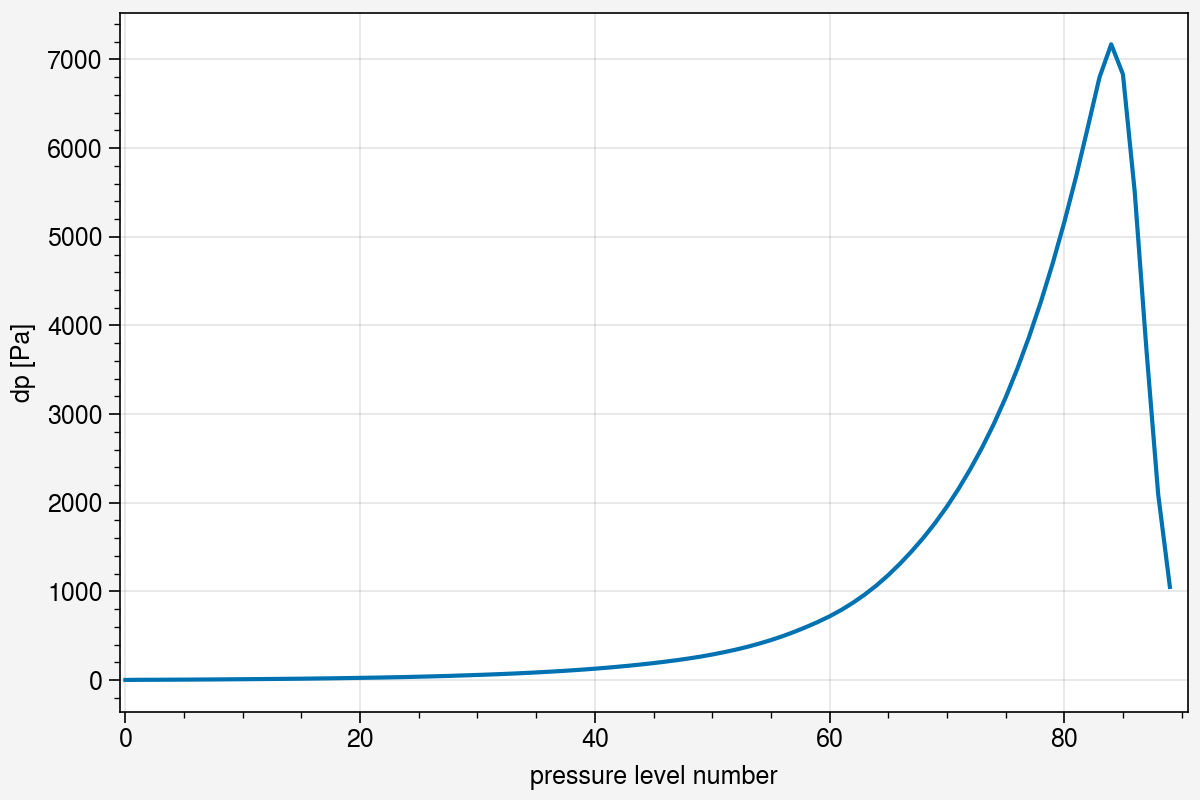

In [11]:
vert_weights = vertical_weights(ds_zm)
total_weights = weights(ds_zm)
fig, ax = pplt.subplots(figsize=(6,4))
ax.plot(np.arange(0,vert_weights.size,1), vert_weights*100)
ax.set_ylabel('dp [Pa]')
ax.set_xlim([-0.5, 90.5])
ax.set_xlabel('pressure level number')
#fig.savefig('mean_dp_plev.png')

## Streamfunction calculation via TropD package

function: 

$ \frac{2\pi a cos \phi}{g} \int_{0}^{p} v dp $

In [12]:
ds = ds_zm.mean('time')
psi = tropdf.TropD_Calculate_StreamFunction(ds.vm1.values.T, 
                                            ds.lat.values,
                                            ds.plev.values)
ds_zm['psi'] = (['plev', 'lat'], psi.T)

r_air = 287
cp = 1003
rho_0 = 1.225
n = 1.2e-2 # Brunt-Väisälä frequency s^-1, strat: n^2 = 4e-4 s^-2
scale_height = 7000

ds_zm['psi'] = (['plev', 'lat'], psi.T)
ds_zm['theta'] = calc_theta(ds_zm)
ds_tp['vtheta_et'] = ds_tp.vT_et * (p00/ds_zm.plev) ** (r_air/cp)
ds_zm['z_logp'] = - scale_height * np.log(ds_zm.plev/p00)

nlevs = ds_zm.plev.size
ds_sel = ds_zm.isel(plev=slice(1,nlevs-1))
ds = ds_zm 


dtheta_dp = calc_da_derivative(ds.theta, ds.plev)
vtheta_et_scaled_dp = calc_da_derivative(ds_tp.vtheta_et.mean('time')/dtheta_dp.mean('time'), ds.plev)

#dtheta_dp = ds.theta.differentiate('plev') / 100
#vtheta_et_scaled_dp = (ds_tp.vtheta_et.mean('time')/dtheta_dp.mean('time')).differentiate('plev') / 100

ds_zm['psi_star'] = (ds_zm.psi - np.cos(np.radians(ds_zm.lat)) * 2 * np.pi * r_e / g0 
                     * ds_tp.vtheta_et.mean('time')/dtheta_dp.mean('time'))

ds_zm['v_star'] = ds_zm.vm1.mean('time') - vtheta_et_scaled_dp

psi_alt = tropdf.TropD_Calculate_StreamFunction(ds_zm.v_star.values.T, 
                                            ds_zm.lat.values,
                                            ds_zm.plev.values)

ds_zm['psi_star_alt'] = (['plev', 'lat'], psi_alt.T)

## concat all datasets

In [13]:
# calculate the jet separation index as |lat_stj - lat_edj|  
f_res = '1D'
ds_js = calc_jet_sep_index(ds_zm, resample_freq=f_res)

In [14]:
# Extend in time by a few NaN values to avoid counting the hemisphere switch as transition
# concat hemispheres in time to have a time series to analyze
ds_js_concat = concat_hems_in_time_xr(ds_js, mode='hemisphere', interruption=5)
ds_zm = concat_hems_in_time_xr(ds_zm, interruption=5)
#ds_pls = concat_hems_in_time_xr(ds_pls, interruption=5)

ds_tp = concat_hems_in_time_xr(ds_tp, interruption=5)
ds_tp_int = concat_hems_in_time_xr(ds_tp_int, interruption=5)
ds_ep = concat_hems_in_time_xr(ds_ep, interruption=5)
ds_eq = concat_hems_in_time_xr(ds_eq, interruption=5)

## Jet separation index

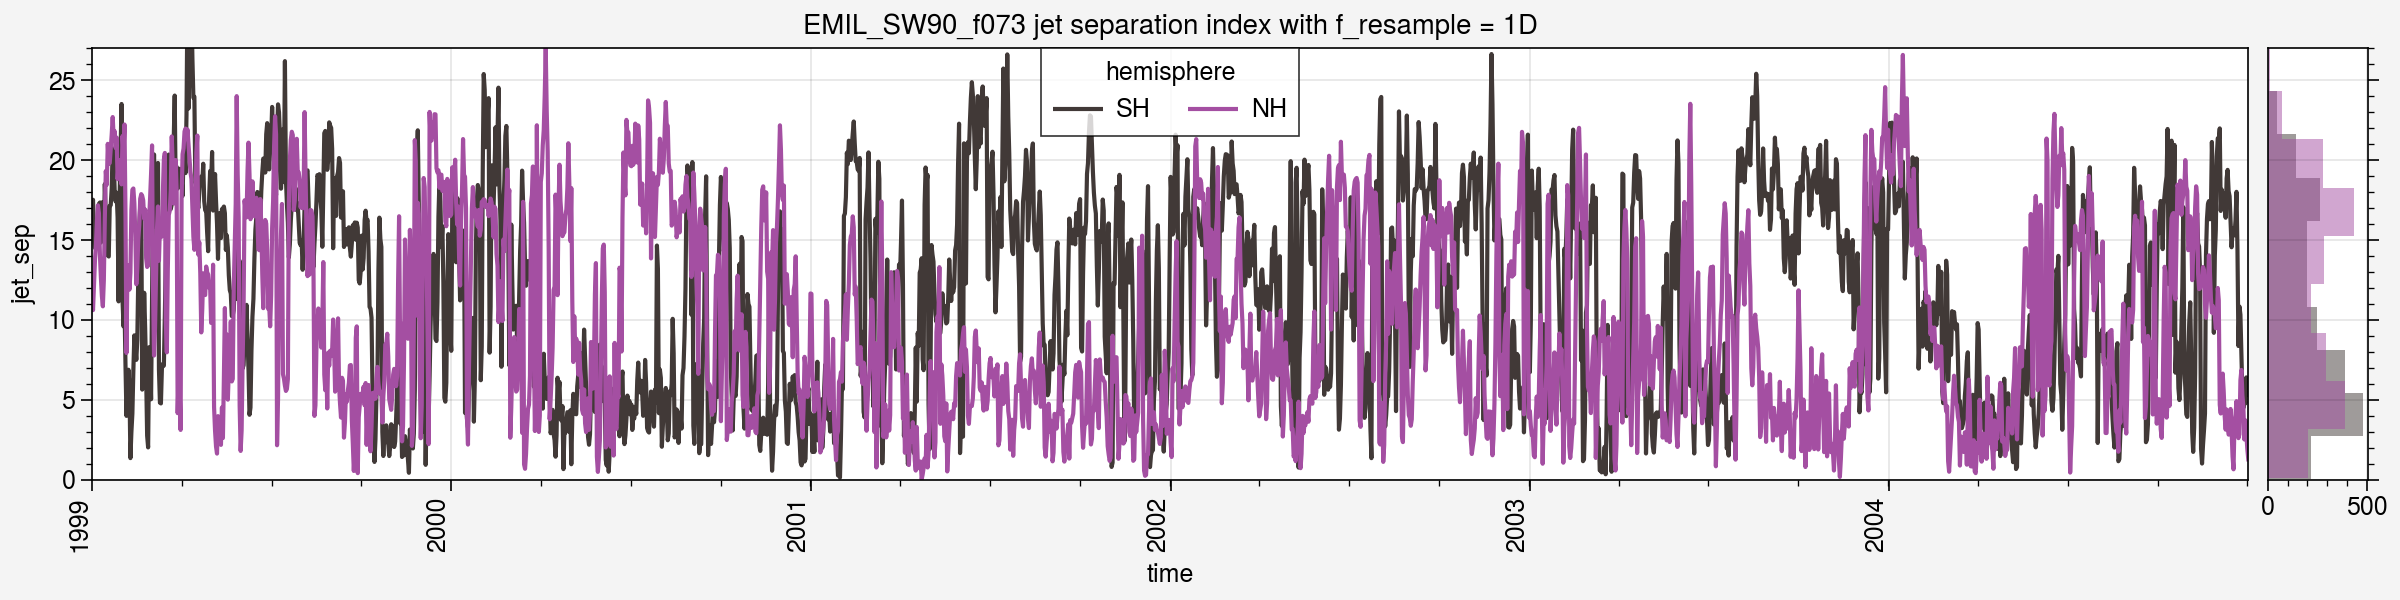

In [31]:
fig, ax = pplt.subplots(figsize=(12,3))
ds_js.jet_sep.plot.line(x='time', cycle=colorcycle)

ax.set_title(f'{exp_name} jet separation index with f_resample = {f_res}')
if 'trans_date' in ds_zm:
    trans_date = np.datetime_as_string(ds_zm.trans_date.values, unit='D')
    ax.set_title(f'{exp_name} jet separation index with f_resample = {f_res}, transition at {trans_date}')

ax.set_ylim([0,27])

p_right = ax.panel('right')

p_right.hist(ds_js.jet_sep.sel(hemisphere='NH'), orientation='horizontal', alpha=0.5, color=colorlist[0])
p_right.hist(ds_js.jet_sep.sel(hemisphere='SH'), orientation='horizontal', alpha=0.5, color=colorlist[1])


fig.savefig(f'{exp_name}_jet_separation_index_{f_res}.{plot_format}')

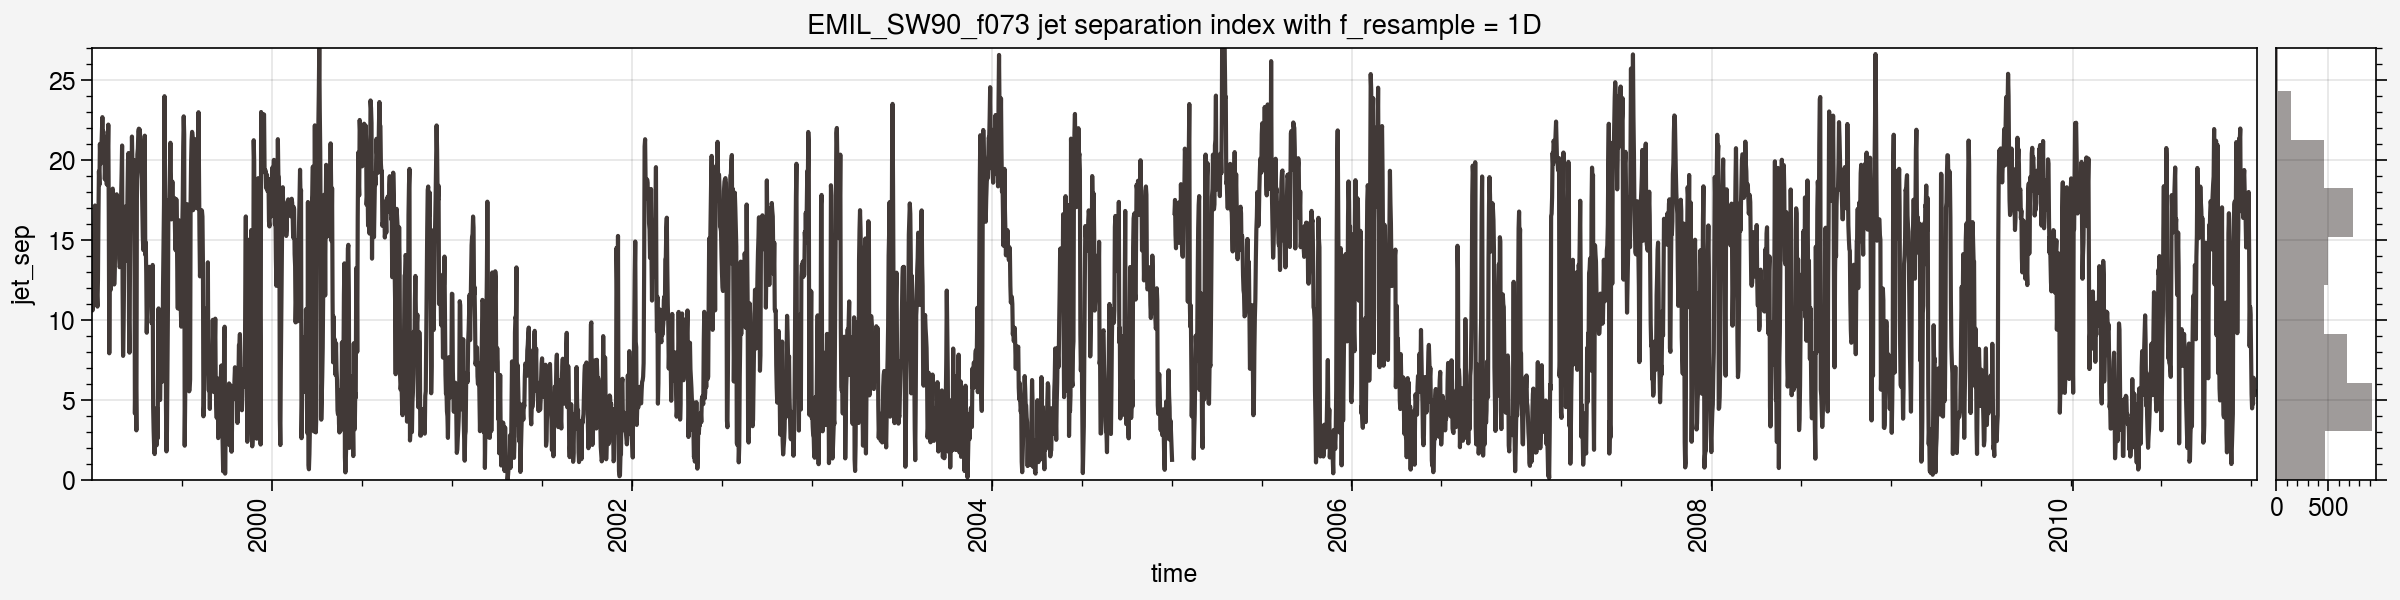

In [34]:
fig, ax = pplt.subplots(figsize=(12,3))
ds_js_concat.jet_sep.plot.line(x='time', color=colorlist[0])

ax.set_title(f'{exp_name} jet separation index with f_resample = {f_res}')
ax.set_ylim([0,27])

p_right = ax.panel('right')

p_right.hist(ds_js_concat.jet_sep, orientation='horizontal', alpha=0.5, color=colorlist[0])

fig.savefig(f'{exp_name}_jet_separation_index_{f_res}.{plot_format}')

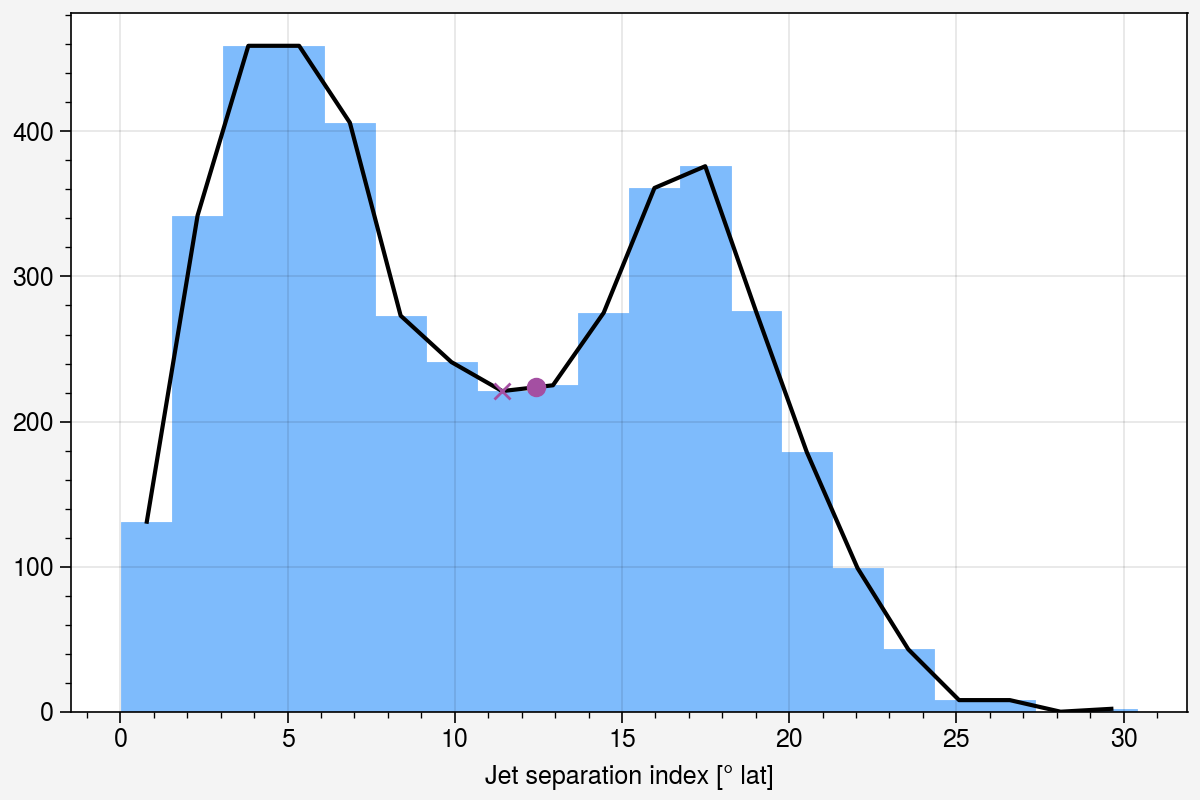

In [37]:
# manually set which minimum is the one between the peaks (run and reset)
nth_min = 0

fig, ax = pplt.subplots(figsize=(6,4))
n, bins, _ = plt.hist(ds_js.stack(time_index=('time','hemisphere')).jet_sep, bins=20, color=colordict['himmelblau'])

bin_midpoints = (bins[:-1] + bins[1:]) * 0.5 
ax.plot(bin_midpoints, n, color='black')

def minima_indices(a):
    """
    Finds local minima in a.
    Returns:
        boolean array with indices.
    """
    indices = ((a <= np.roll(a, 1)) & (a <= np.roll(a, -1)))
    
    return indices

def minimum_interp(a, x, nth_minimum=0):
    
    i_min = minima_indices(a)
    i_nth_min = (np.argwhere(i_min == True)[nth_min])[0]

    i_start = i_nth_min-1
    i_end = i_nth_min+2
    
    derivative = np.gradient(n[i_start:i_end], bin_midpoints[i_start:i_end])
    f_inv = scipy.interpolate.interp1d(derivative, bin_midpoints[i_start:i_end])
    f = scipy.interpolate.interp1d(bin_midpoints[i_start:i_end], a[i_start:i_end])
    min_pos = f_inv(0)
    min_val = f(min_pos)
    
    return min_pos, min_val

i_min = minima_indices(n)
ax.plot(bin_midpoints[i_min][nth_min], n[i_min][nth_min], 'x', color=colordict['lila'])

min_pos, min_val = minimum_interp(n, bin_midpoints, nth_minimum=nth_min)
ax.plot(min_pos, min_val, 'o', color=colordict['lila'])
ax.set_xlabel('Jet separation index [° lat]')

fig.savefig(f'{exp_name}_jet_separation_distribution.{plot_format}')

In [ ]:
threshold = min_pos
min_length = 5 # length in days  = f_res * n
min_length_days = min_length/np.ceil(int(f_res[0]))

first_color = colordict['sandstein']
second_color = colordict['meerblau']

ymax = 30
arrow_base = ymax-3

# find all dates where jets are more separated than threshold
sep_start, sep_end, sep_data = s2stools.events.blocks_where(
    data=ds_js_concat.jet_sep.values, condition=(ds_js_concat.jet_sep > threshold)
)
sep_start = np.array(sep_start)
sep_end = np.array(sep_end)

# find all dates where jets are less separated than threshold
join_start, join_end, join_data = s2stools.events.blocks_where(
    data=ds_js_concat.jet_sep.values, condition=(ds_js_concat.jet_sep < threshold)
)
join_start = np.array(join_start)
join_end = np.array(join_end)

# find events longer than the minimum length
i_sep = (sep_end - sep_start > min_length)
i_join = (join_end - join_start > min_length)

# plot data
fig, ax = pplt.subplots(figsize=(13, 3))
ax.plot(np.arange(ds_js_concat.time.size), ds_js_concat.jet_sep, color=colordict['granitgrau'])

def plot_event_times(events_start, events_end, color='gray', fig=None, ax=None):

    if fig is None:
        fig, ax = pplt.subplots(figsize=(13, 3))
        
    for s, e in zip(events_start, events_end):
        ax.axvspan(s, e, alpha=0.4, color=color)
        #ax.text((s + e) / 2, -2.5, f"max = {d.max():.1f}", rotation=90, ha="center")
    
    return fig, ax

sep_start = sep_start[i_sep]
sep_end = sep_end[i_sep]
join_start = join_start[i_join]
join_end = join_end[i_join]

# plot event selection 
fig, ax = plot_event_times(sep_start, sep_end, color=first_color, fig=fig, ax=ax)
fig, ax = plot_event_times(join_start, join_end, color=second_color, fig=fig, ax=ax)

# plot transition events
separation_events = np.intersect1d(join_end, sep_start)
merge_events = np.intersect1d(sep_end, join_start)

plt.vlines(separation_events, ymin=arrow_base, ymax=ymax, color=first_color)
ax.plot(separation_events, np.ones(separation_events.size) * arrow_base, 'v', color=first_color)

plt.vlines(merge_events, ymin=arrow_base, ymax=ymax, color=second_color)
ax.plot(merge_events, np.ones(merge_events.size) * arrow_base, 'v', color=second_color)

fig.suptitle(f'Jet separation periods for {exp_name}')
ax.set_title(
    f'threshold value: {threshold:.2f} °, minimum length: {min_length_days:.0f} days, No of separation events: {separation_events.size}; No of merge events: {merge_events.size}'
)
ax.set_xlabel('days after experiment start')
ax.set_ylabel('jet separation index [°]')
ax.set_xlim([-5, ds_js_concat.time.size+5])
ax.set_ylim([0,ymax])
plt.show()

fig.savefig(f'{exp_name}_jet_separation_with_periods_{min_length_days}.{plot_format}')

In [35]:
colordict

{'granitgrau': '#413937',
 'lila': '#A44FA2',
 'gruen': '#96A129',
 'himmelblau': '#7EBBFC',
 'gold': '#F8C508',
 'granitbraun': '#6D6260',
 'sandstein': '#AB8F81',
 'flieder': '#B18CB5',
 'dunkelgruen': '#2D3609',
 'meerblau': '#799CC2',
 'dunkelgelb': '#987823',
 'braun': '#4E321C'}

## Event Analysis

In [12]:
merge_event_dates = ds_js_concat.time[merge_events]
separation_event_dates = ds_js_concat.time[separation_events]


### merge events

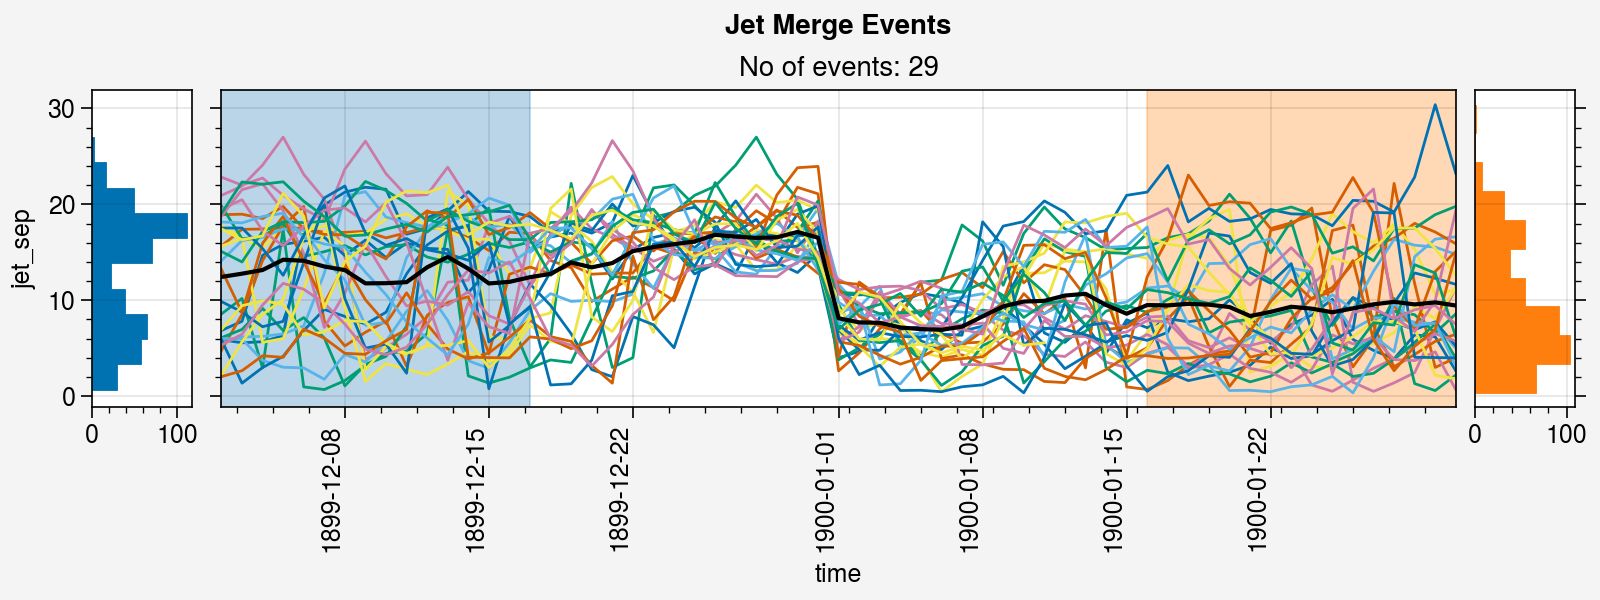

In [14]:
ds_js_e = event_dates_to_dataset(ds_js_concat, merge_event_dates, n_days_before=30, n_days_after=30)


fig, ax = plot_jet_sep_events_timeseries(ds_js_e.jet_sep, n_date_sep=15)

fig.suptitle(f'Jet Merge Events')
ax.set_title(f'No of events: {ds_js_e.event.size}')
fig.savefig(f'merge_event_spaghetti.{plot_format}')

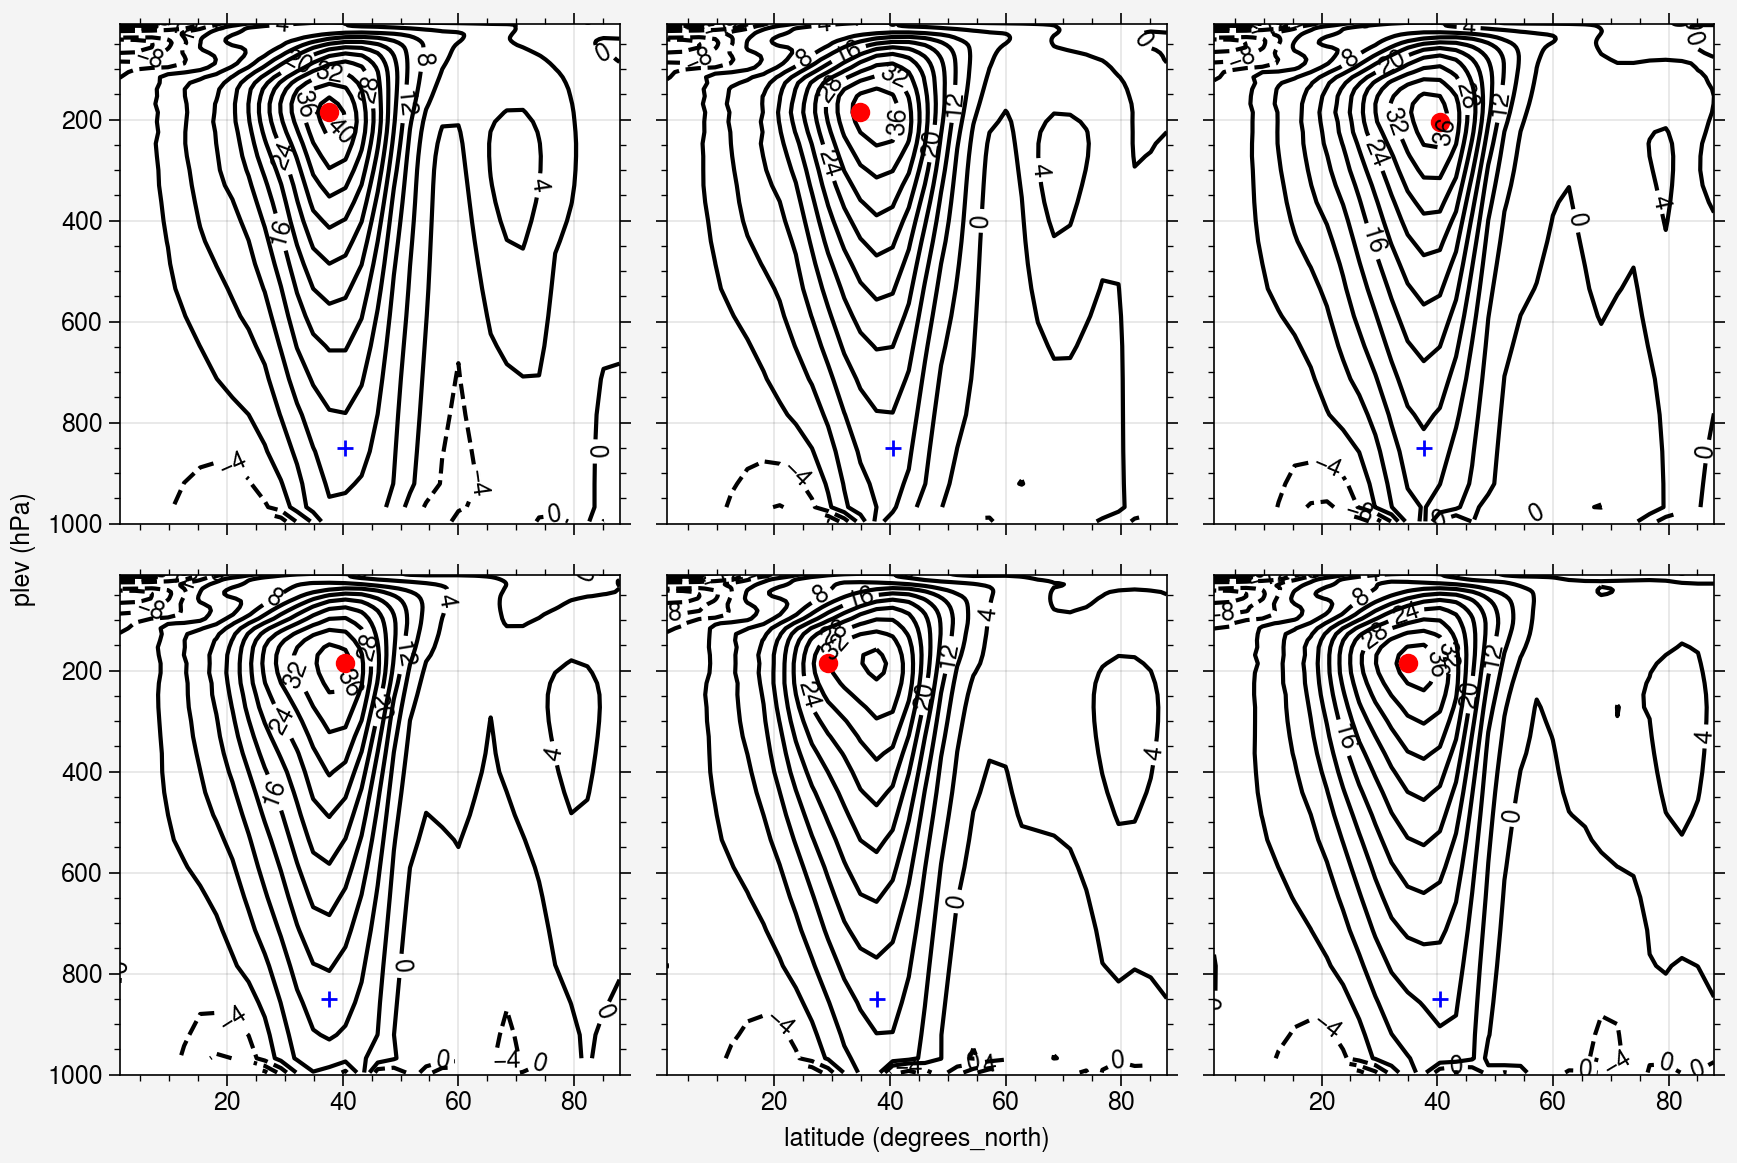

In [58]:
ds = event_dates_to_dataset(ds_zm, merge_event_dates, n_days_before=3, n_days_after=3)
fig, ax = pplt.subplots(ncols=3, nrows=2)

for j in ds.event.values[:4]:
    for i,a in enumerate(ax):
        a.clear()
        #wind = ds.um1.isel(time=slice(5*i, 5*i+3)).mean('time').sel(event=j)
        wind = ds.um1.isel(time=i, event=j)
        a.contour(ds.lat, ds.plev, wind, color='black', levels=16, labels=True)
        lat_edj, lat_stj, pl_edj, pl_stj = calc_jet_lats(wind)

        a.plot(lat_stj.values, pl_stj, 'o', color='red', lw=15)
        a.plot(lat_edj.values, pl_edj, '+', color='blue', lw=15)

        a.set_ylim([1000,10])
    fig.savefig(f'merge_event_{j}_wind_evolution.{plot_format}')
    

### separation events

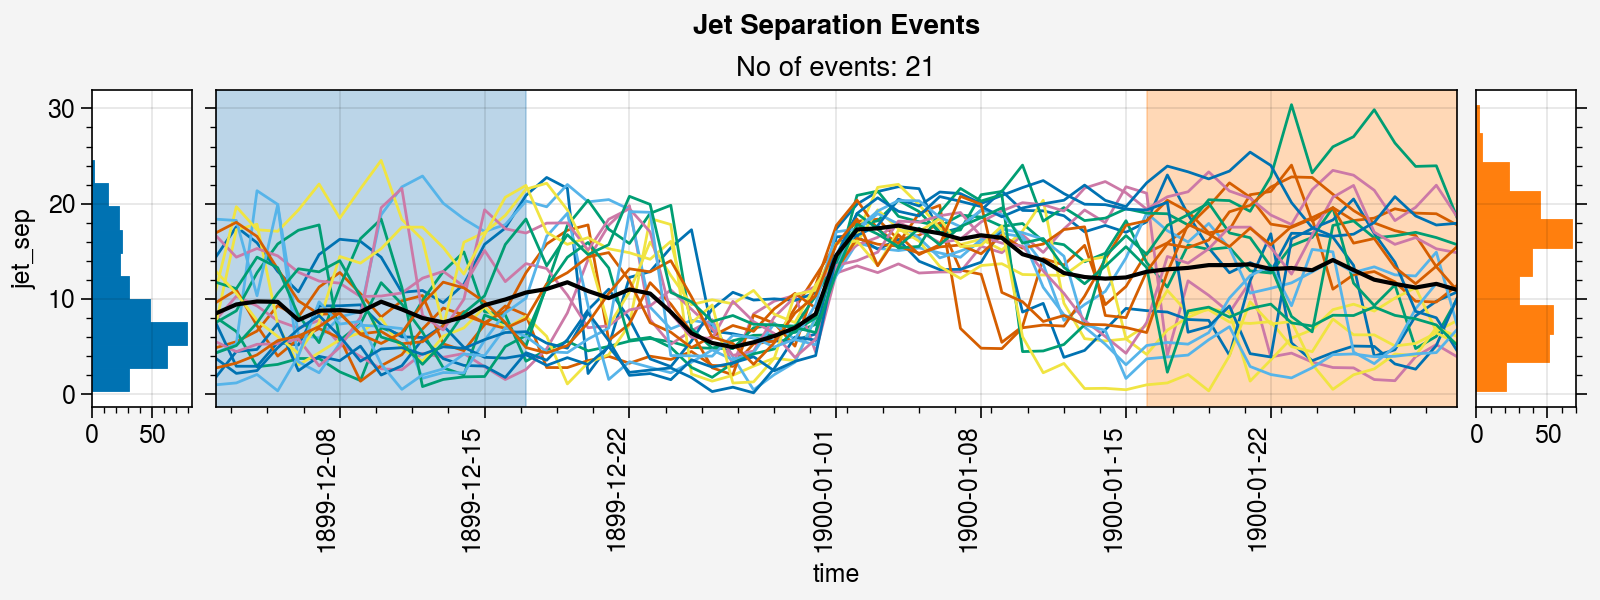

In [14]:
ds_js_e = event_dates_to_dataset(ds_js_concat, separation_event_dates, n_days_before=30, n_days_after=30)

fig, ax = plot_jet_sep_events_timeseries(ds_js_e.jet_sep, n_date_sep=15)

fig.suptitle(f'Jet Separation Events')
ax.set_title(f'No of events: {ds_js_e.event.size}')
fig.savefig(f'separation_event_spaghetti.{plot_format}')

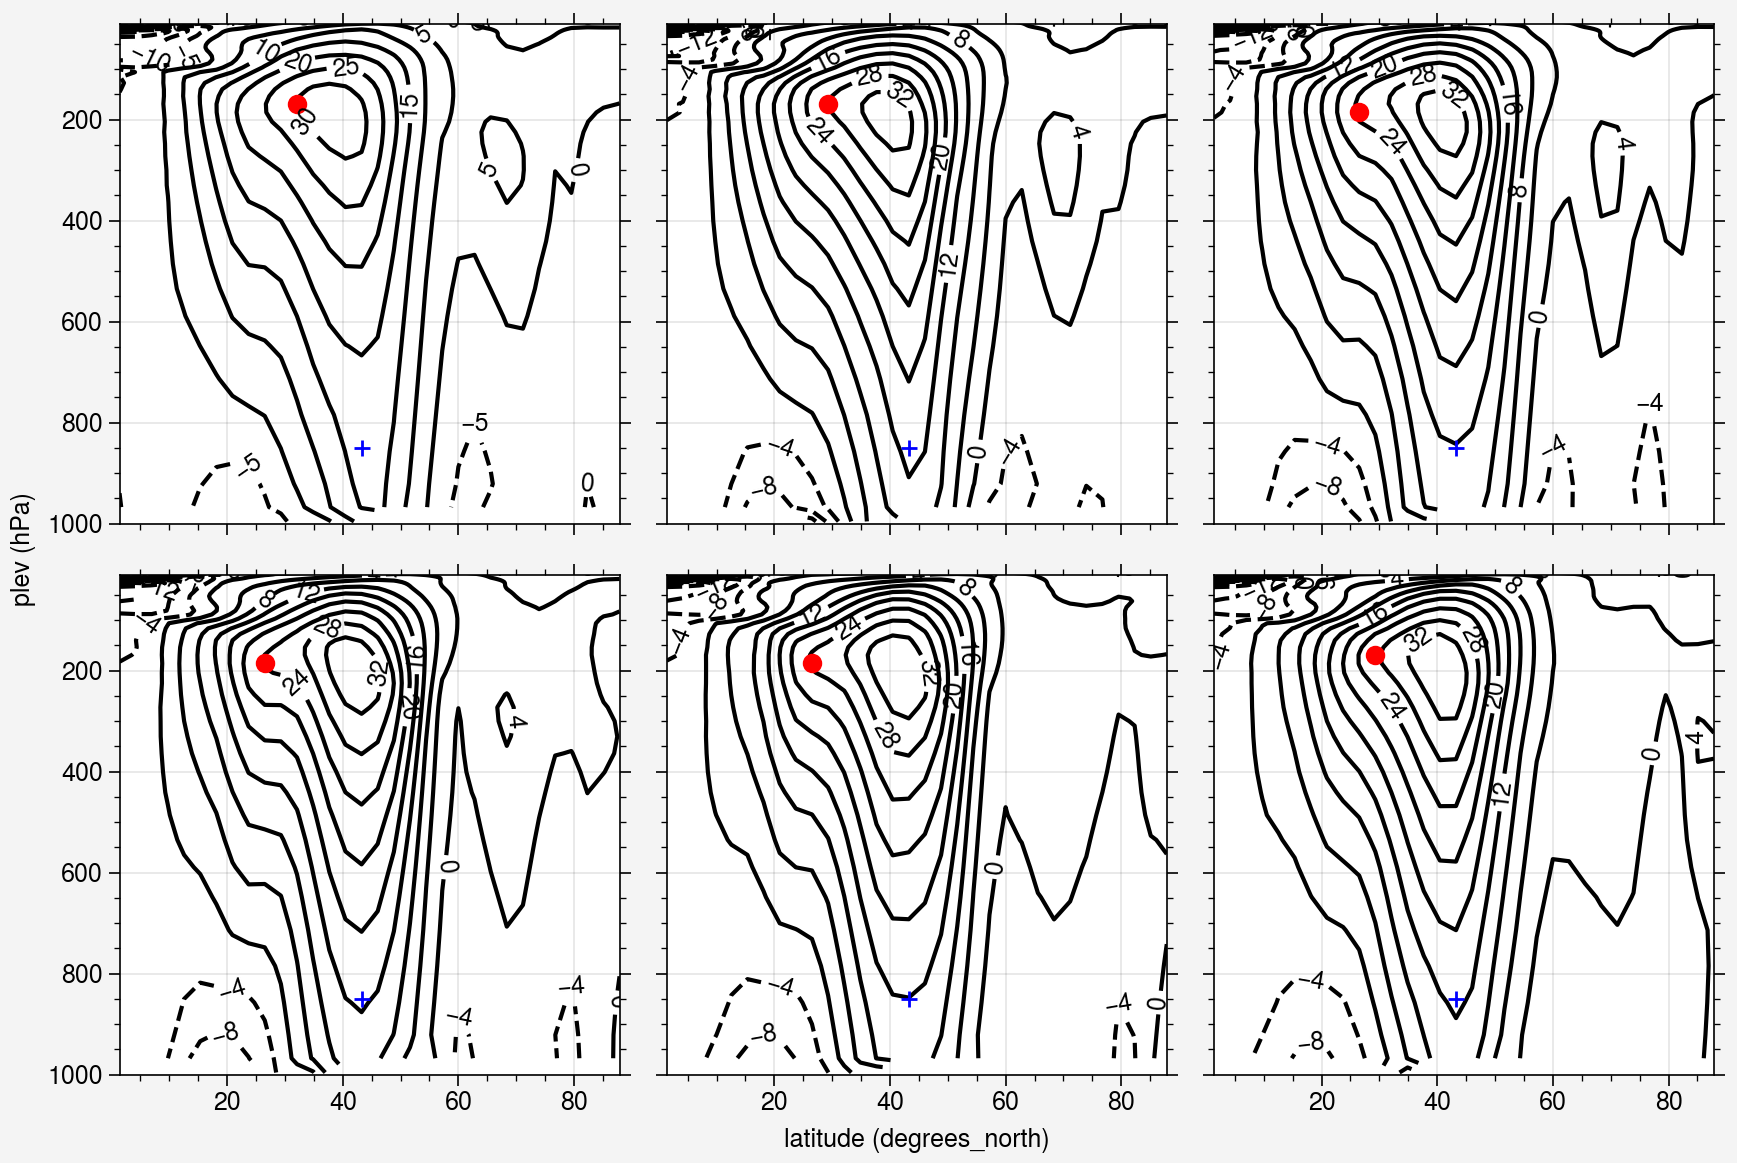

In [57]:
ds = event_dates_to_dataset(ds_zm, separation_event_dates, n_days_before=3, n_days_after=3)
fig, ax = pplt.subplots(ncols=3, nrows=2)

for j in ds.event.values:
    for i,a in enumerate(ax):
        a.clear()
        #wind = ds.um1.isel(time=slice(5*i, 5*i+3)).mean('time').sel(event=j)
        wind = ds.um1.isel(time=i, event=j)
        a.contour(ds.lat, ds.plev, wind, color='black', levels=16, labels=True)
        lat_edj, lat_stj, pl_edj, pl_stj = calc_jet_lats(wind)

        a.plot(lat_stj.values, pl_stj, 'o', color='red', lw=15)
        a.plot(lat_edj.values, pl_edj, '+', color='blue', lw=15)

        a.set_ylim([1000,10])
    fig.savefig(f'separation_event_{j}_wind_evolution.{plot_format}')
    

In [15]:
ds_zm_events = event_dates_to_dataset(ds_zm, merge_event_dates)
ds_zm_events


<xarray.Dataset>
Dimensions:       (event: 29, lat: 64, plev: 90, time: 41)
Coordinates:
  * time          (time) datetime64[ns] 1899-12-12 1899-12-13 ... 1900-01-21
  * plev          (plev) float32 0.009946 0.03183 0.05808 ... 995.7 1.009e+03
  * lat           (lat) float32 87.86 85.1 82.31 79.53 ... -82.31 -85.1 -87.86
  * event         (event) int64 0 1 2 3 4 5 6 7 8 ... 20 21 22 23 24 25 26 27 28
    hemisphere    (event) <U2 'NH' 'NH' 'NH' 'NH' 'NH' ... 'SH' 'SH' 'SH' 'SH'
Data variables: (12/14)
    um1           (event, time, plev, lat) float64 -0.2034 -0.3388 ... nan nan
    vm1           (event, time, plev, lat) float64 0.1001 0.1592 ... nan nan
    vervel        (event, time, plev, lat) float64 5.478e-07 8.29e-08 ... nan
    tm1           (event, time, plev, lat) float64 201.6 201.8 201.9 ... nan nan
    aps           (event, time, lat) float64 9.807e+04 9.814e+04 ... nan nan
    geopot_p      (event, time, plev, lat) float64 6.795e+05 6.795e+05 ... nan
    ...            ...
    theta         (event, time, plev, lat) float64 5.467e+03 5.473e+03 ... nan
    z_logp        (event, plev) float32 8.072e+04 7.258e+04 ... 120.9 25.34
    psi_star      (event, plev, lat) float64 0.9381 11.22 42.5 ... nan nan nan
    v_star        (event, plev, lat) float32 -0.009854 -0.02258 ... nan nan
    psi_star_alt  (event, plev, lat) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    event_date    (event) datetime64[ns] 1999-08-15 2000-03-01 ... 2010-12-26

# Old Code

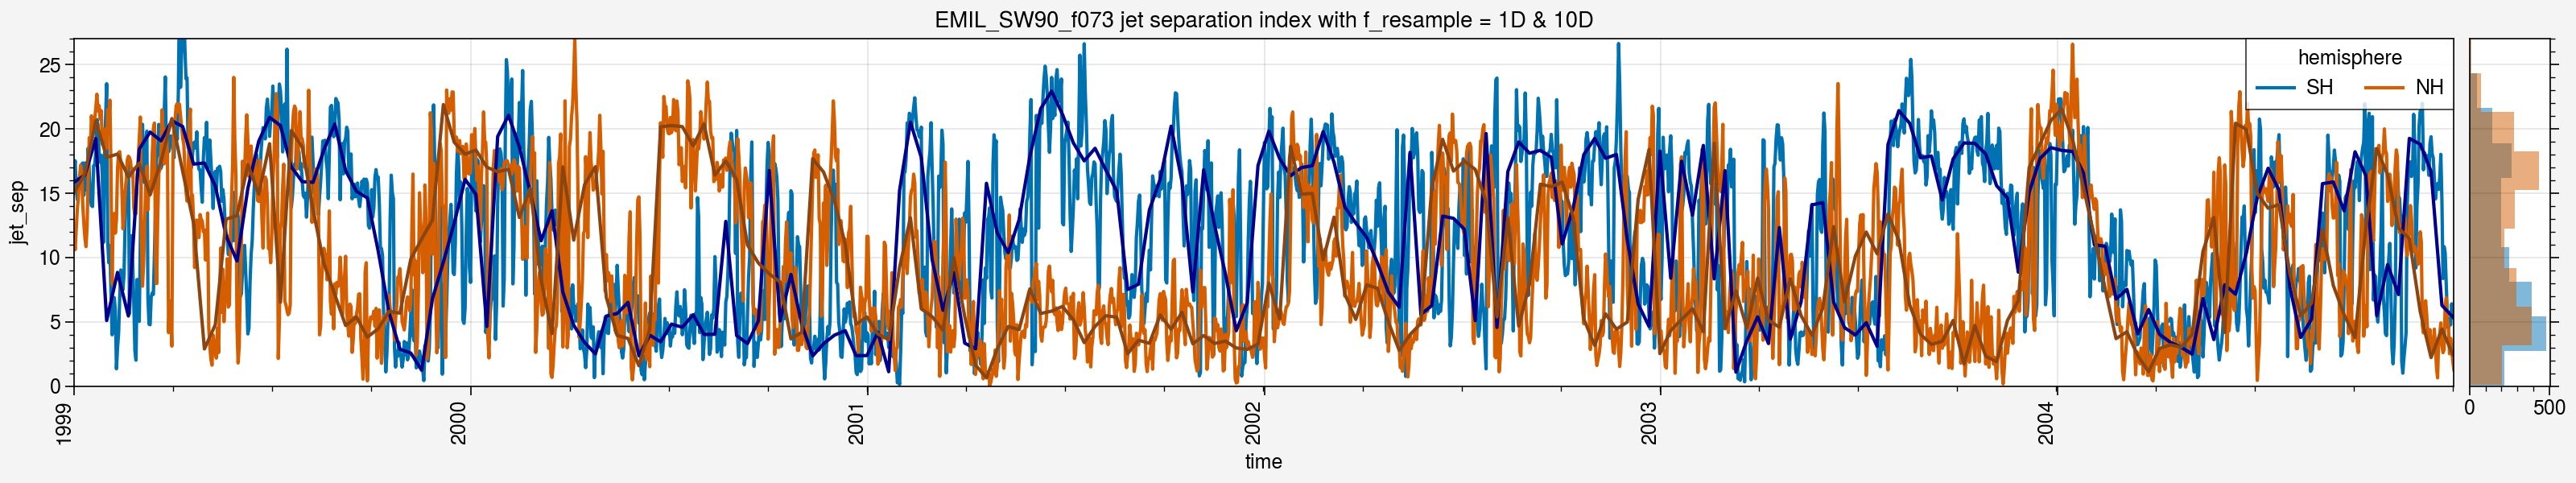

In [16]:
f_res_2 = '10D'
fig, ax = pplt.subplots(figsize=(16,3))
ds_js_2 = calc_jet_sep_index(ds_zm, resample_freq=f_res_2)
ds_js.jet_sep.plot.line(x='time')

ax.plot(ds_js_2.time, ds_js_2.jet_sep.sel(hemisphere='SH'), color='darkblue')
ax.plot(ds_js_2.time, ds_js_2.jet_sep.sel(hemisphere='NH'), color='saddlebrown')

ax.set_title(f'{exp_name} jet separation index with f_resample = {f_res} & {f_res_2}')
if 'trans_date' in ds_zm:
    trans_date = np.datetime_as_string(ds_zm.trans_date.values, unit='D')
    ax.set_title(f'{exp_name} jet separation index with f_resample = {f_res}, transition at {trans_date}')

ax.set_ylim([0,27])

p_right = ax.panel('right')

p_right.hist(ds_js.jet_sep.sel(hemisphere='NH'), orientation='horizontal', alpha=0.5)
p_right.hist(ds_js.jet_sep.sel(hemisphere='SH'), orientation='horizontal', alpha=0.5)


fig.savefig(f'{exp_name}_jet_separation_index_{f_res}_{f_res_2}.{plot_format}')

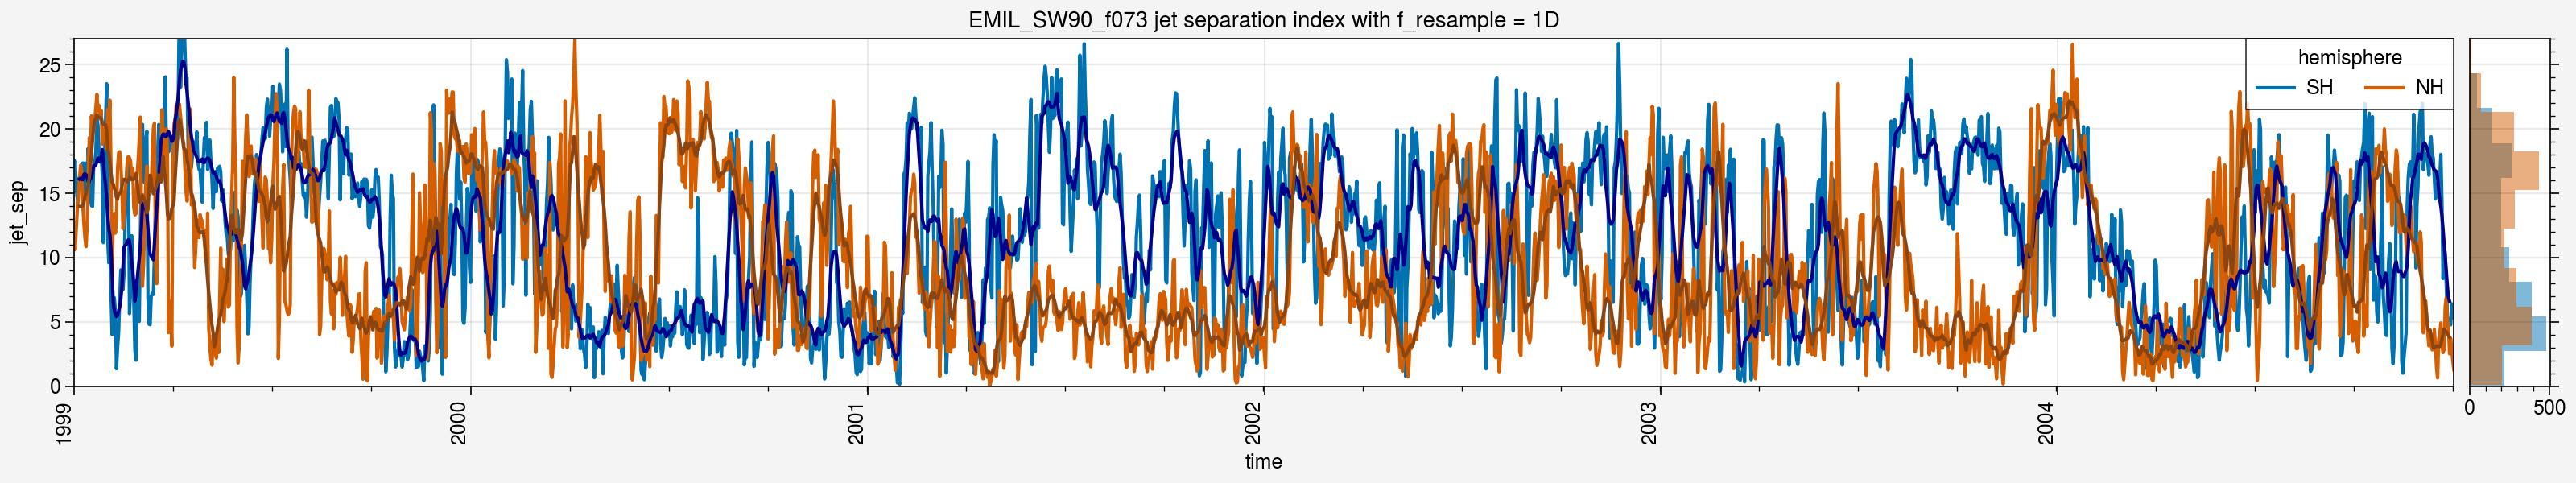

In [17]:
f_res = '1D'
fig, ax = pplt.subplots(figsize=(16,3))
#ds_js = calc_jet_sep_index(ds_zm, resample_freq=f_res)
ds_js.jet_sep.plot.line(x='time')

n_smooth = 10
ax.plot(ds_js.time, ds_js.jet_sep.rolling(time=n_smooth, center=True).mean('time').sel(hemisphere='SH'), color='darkblue')
ax.plot(ds_js.time, ds_js.jet_sep.rolling(time=n_smooth, center=True).mean('time').sel(hemisphere='NH'), color='saddlebrown')

ax.set_title(f'{exp_name} jet separation index with f_resample = {f_res}')
if 'trans_date' in ds_zm:
    trans_date = np.datetime_as_string(ds_zm.trans_date.values, unit='D')
    ax.set_title(f'{exp_name} jet separation index with f_resample = {f_res}, transition at {trans_date}')

ax.set_ylim([0,27])

p_right = ax.panel('right')

p_right.hist(ds_js.jet_sep.sel(hemisphere='NH'), orientation='horizontal', alpha=0.5)
p_right.hist(ds_js.jet_sep.sel(hemisphere='SH'), orientation='horizontal', alpha=0.5)


fig.savefig(f'{exp_name}_jet_separation_index_{f_res}.{plot_format}')